# **Dataset Kualitas Lingkungan sungai Oyo (Data Pribadi)**

## Import Library

In [122]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

# Data Wrangling

## Data Akuisisi

In [129]:
# koneksikan dengan drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# ambil data
file_path = '/content/drive/MyDrive/AQUASENSE/data_sensor.csv'
data = pd.read_csv(file_path)

In [131]:
# Baca dataset dari CSV
data.head()

,Id,Waktu,dht_them (°C),dht_hum (%),ds_them (°C),Cuaca
0,1,03/11/2024 06:05,29.1,74.3,26.56,0
1,2,03/11/2024 06:06,29.1,74.6,26.56,0
2,3,03/11/2024 06:06,28.8,75.4,26.50,0
3,4,03/11/2024 06:07,28.7,76.0,26.50,0
4,5,03/11/2024 06:07,28.6,76.5,26.56,0


In [132]:
# jumlah data
print(len(data))

1035


## Data Asessing

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          1035 non-null   int64  
 1   Waktu       1035 non-null   object 
 2   suhu udara  1035 non-null   float64
 3   humidty     1035 non-null   float64
 4   suhu air    1035 non-null   float64
 5   Cuaca       1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [74]:
data.isna().sum()

,0
Id,0
Waktu,0
suhu udara,0
humidty,0
suhu air,0
Cuaca,0


In [75]:
print('duplikasi data: ', data.duplicated().sum())

duplikasi data:  0


In [76]:
data.describe()

,Id,suhu udara,humidty,suhu air,Cuaca
count,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000
mean,518.000000,26.028213,90.079324,26.028135,0.351691
std,298.923067,2.389920,8.049359,3.227054,0.477729
min,1.000000,23.600000,68.400000,20.310000,0.000000
25%,259.500000,24.000000,81.700000,24.000000,0.000000
50%,518.000000,24.900000,95.400000,24.500000,0.000000
75%,776.500000,28.400000,96.300000,26.620000,1.000000
max,1035.000000,31.900000,98.100000,37.440000,1.000000


## Data Cleaning and encoding

kolom cuaca dihapus karena ada banyak nilai yang berisi 0 dibanding 1 dan cuaca ini ambigu karena hanyak menampilkan 0 atau 1 oleh karena itu kolom cuaca dihapus

In [78]:
# Menghapus kolom 'Cuaca'
data = data.drop(columns=['Cuaca'])
data.head()

,Id,Waktu,suhu udara,humidty,suhu air
0,1,03/11/2024 06:05,29.1,74.3,26.56
1,2,03/11/2024 06:06,29.1,74.6,26.56
2,3,03/11/2024 06:06,28.8,75.4,26.50
3,4,03/11/2024 06:07,28.7,76.0,26.50
4,5,03/11/2024 06:07,28.6,76.5,26.56


In [79]:
# encoding waktu ke numerik
df = pd.DataFrame(data)

# Mengonversi kolom 'Waktu' ke format datetime
df['Waktu'] = pd.to_datetime(df['Waktu'], format='%d/%m/%Y %H:%M')
# Mengubah menjadi numerik (timestamp dalam detik sejak epoch)
df['Waktu_numerik'] = df['Waktu'].astype('int64') / 10**9  # Mengonversi ke detik

# Menghapus kolom 'Waktu'
data = data.drop(columns=['Waktu'])
data.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1035 non-null   int64         
 1   Waktu          1035 non-null   datetime64[ns]
 2   suhu udara     1035 non-null   float64       
 3   humidty        1035 non-null   float64       
 4   suhu air       1035 non-null   float64       
 5   Waktu_numerik  1035 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 48.6 KB


In [81]:
df.isna().sum()

,0
Id,0
Waktu,0
suhu udara,0
humidty,0
suhu air,0
Waktu_numerik,0


# Exploratory Data Analisis

In [59]:
df.head()

,Id,Waktu,suhu udara,humidty,suhu air,Waktu_numerik
0,1,2024-11-03 06:05:00,29.1,74.3,26.56,1.730614e+09
1,2,2024-11-03 06:06:00,29.1,74.6,26.56,1.730614e+09
2,3,2024-11-03 06:06:00,28.8,75.4,26.50,1.730614e+09
3,4,2024-11-03 06:07:00,28.7,76.0,26.50,1.730614e+09
4,5,2024-11-03 06:07:00,28.6,76.5,26.56,1.730614e+09


In [60]:
# deskripsi statistik
df.describe()

,Id,Waktu,suhu udara,humidty,suhu air,Waktu_numerik
count,1035.000000,1035,1035.000000,1035.000000,1035.000000,1.035000e+03
mean,518.000000,2024-11-05 04:28:41.565217280,26.028213,90.079324,26.028135,1.730781e+09
min,1.000000,2024-11-03 06:05:00,23.600000,68.400000,20.310000,1.730614e+09
25%,259.500000,2024-11-04 04:42:00,24.000000,81.700000,24.000000,1.730695e+09
50%,518.000000,2024-11-04 06:57:00,24.900000,95.400000,24.500000,1.730703e+09
75%,776.500000,2024-11-07 05:19:30,28.400000,96.300000,26.620000,1.730957e+09
max,1035.000000,2024-11-08 07:40:00,31.900000,98.100000,37.440000,1.731052e+09
std,298.923067,NaN,2.389920,8.049359,3.227054,1.356826e+05


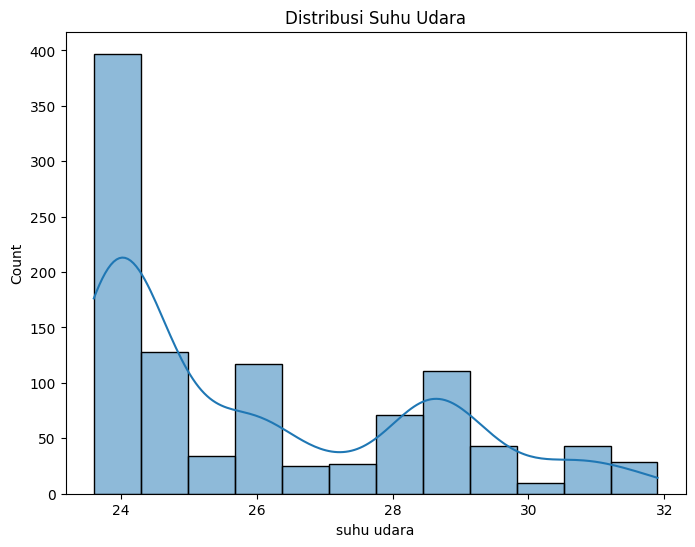

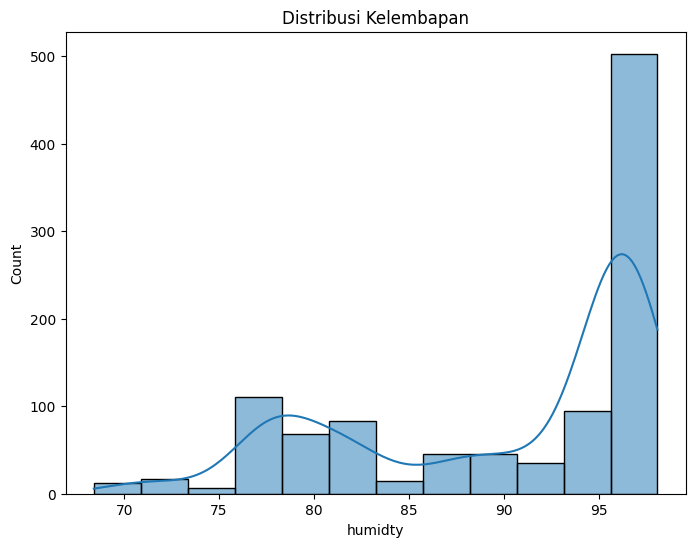

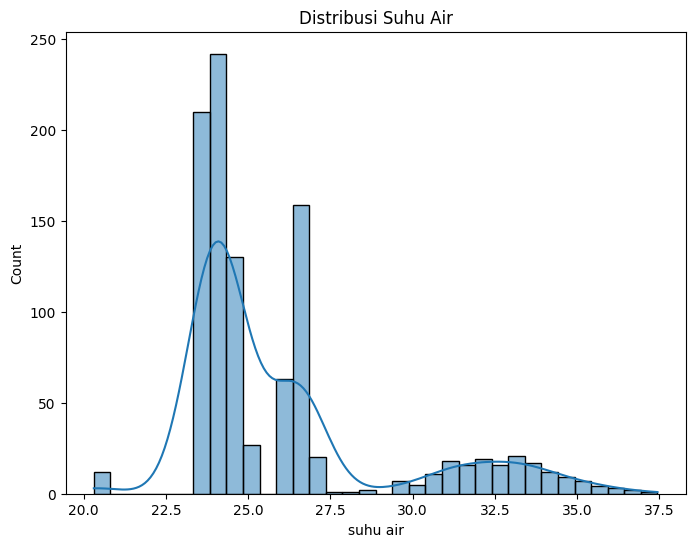

In [61]:
# distribusi data
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['suhu udara'], kde=True)
plt.title('Distribusi Suhu Udara')
plt.show()

sns.histplot(df['humidty'], kde=True)
plt.title('Distribusi Kelembapan')
plt.show()

sns.histplot(df['suhu air'], kde=True)
plt.title('Distribusi Suhu Air')
plt.show()

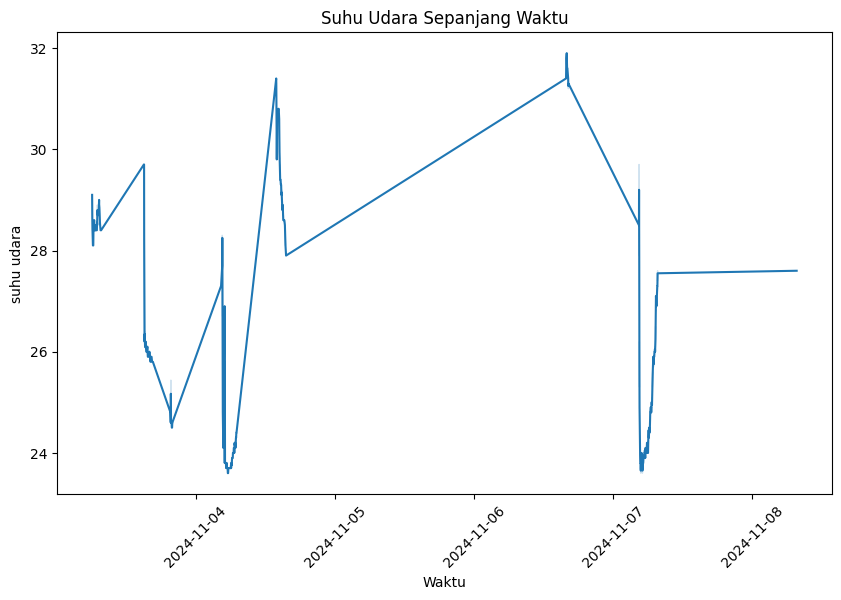

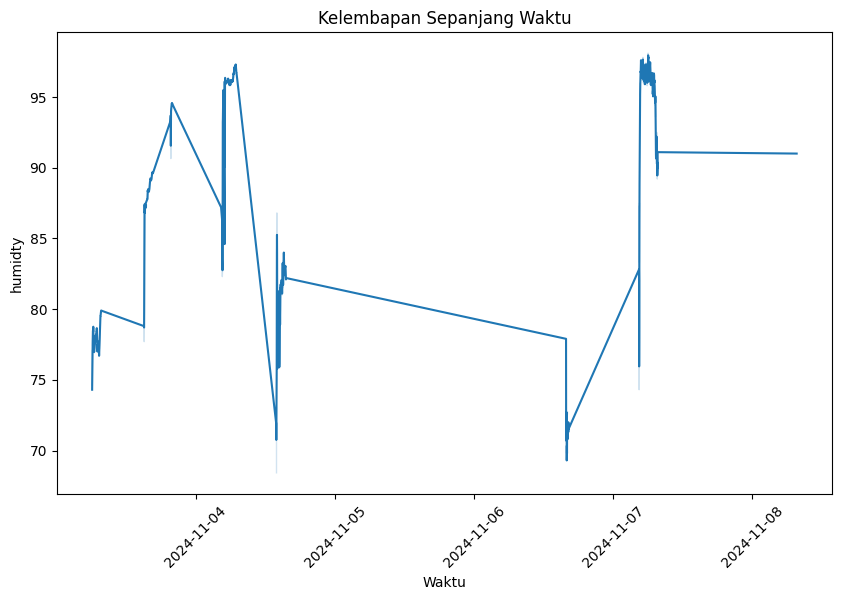

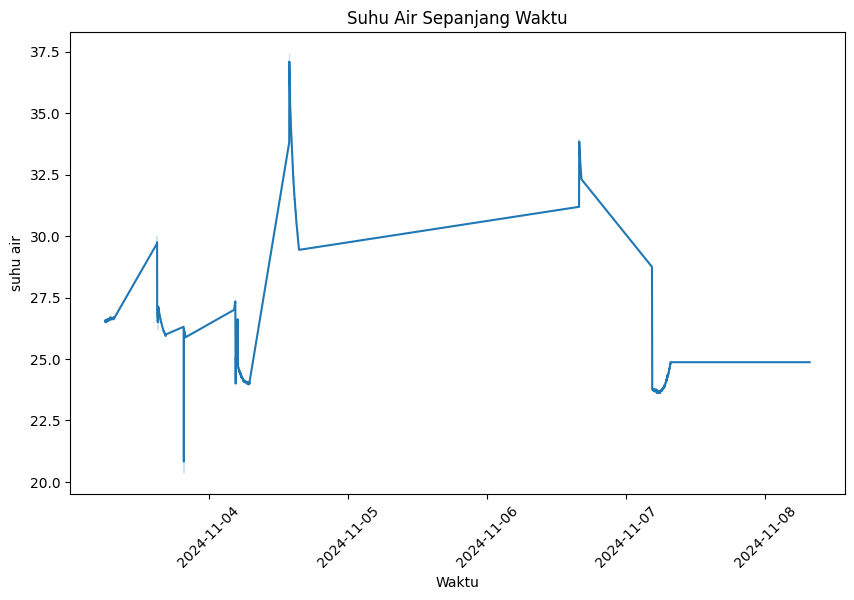

In [62]:
df['Waktu'] = pd.to_datetime(df['Waktu'])

# Plot Suhu Udara terhadap Waktu
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['Waktu'], y=df['suhu udara'])
plt.title('Suhu Udara Sepanjang Waktu')
plt.xticks(rotation=45)
plt.show()

# Plot Kelembapan terhadap Waktu
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['Waktu'], y=df['humidty'])
plt.title('Kelembapan Sepanjang Waktu')
plt.xticks(rotation=45)
plt.show()

# Plot Suhu Air terhadap Waktu
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['Waktu'], y=df['suhu air'])
plt.title('Suhu Air Sepanjang Waktu')
plt.xticks(rotation=45)
plt.show()


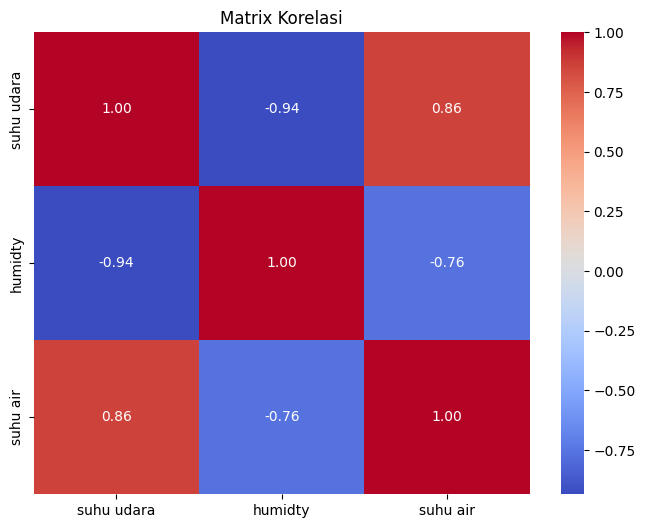

In [63]:
# matriks korelasi
correlation_matrix = df[['suhu udara', 'humidty', 'suhu air']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrix Korelasi')
plt.show()

# Data Prepropcesing

## Cek Outlier

In [64]:
df.head()

,Id,Waktu,suhu udara,humidty,suhu air,Waktu_numerik
0,1,2024-11-03 06:05:00,29.1,74.3,26.56,1.730614e+09
1,2,2024-11-03 06:06:00,29.1,74.6,26.56,1.730614e+09
2,3,2024-11-03 06:06:00,28.8,75.4,26.50,1.730614e+09
3,4,2024-11-03 06:07:00,28.7,76.0,26.50,1.730614e+09
4,5,2024-11-03 06:07:00,28.6,76.5,26.56,1.730614e+09


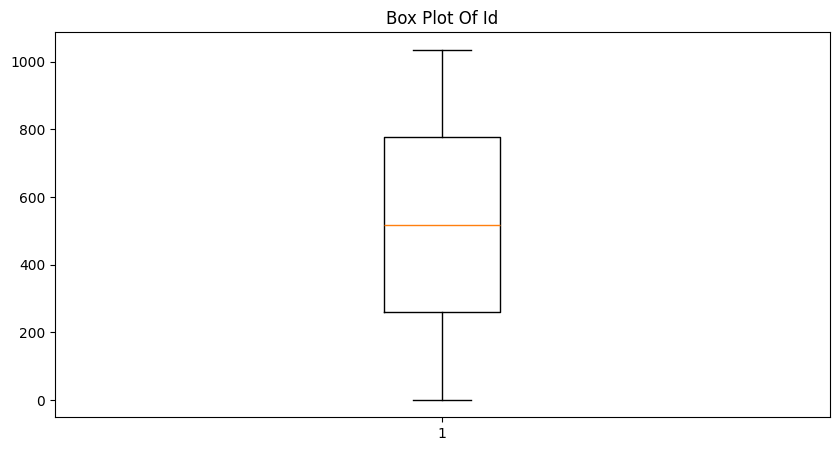

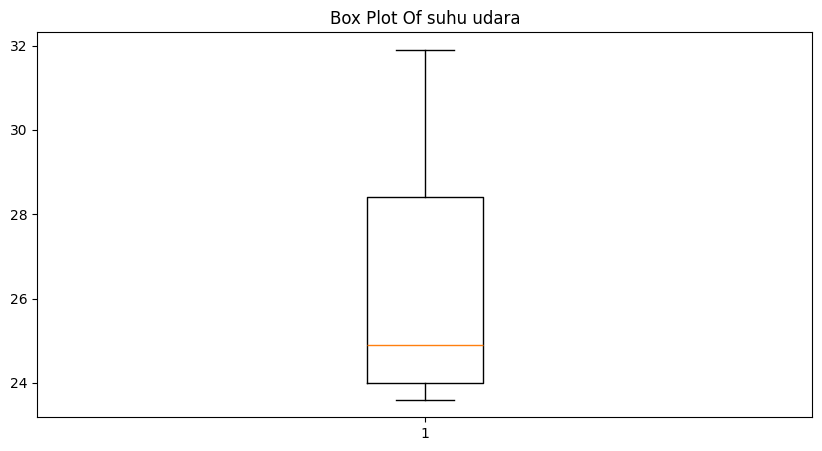

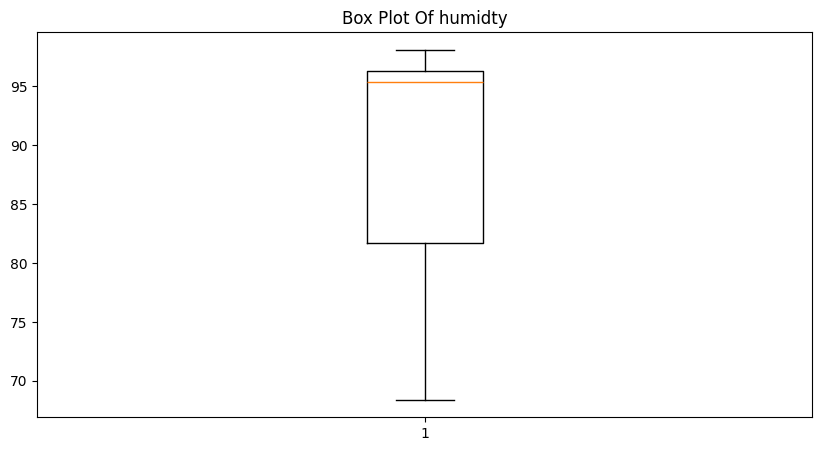

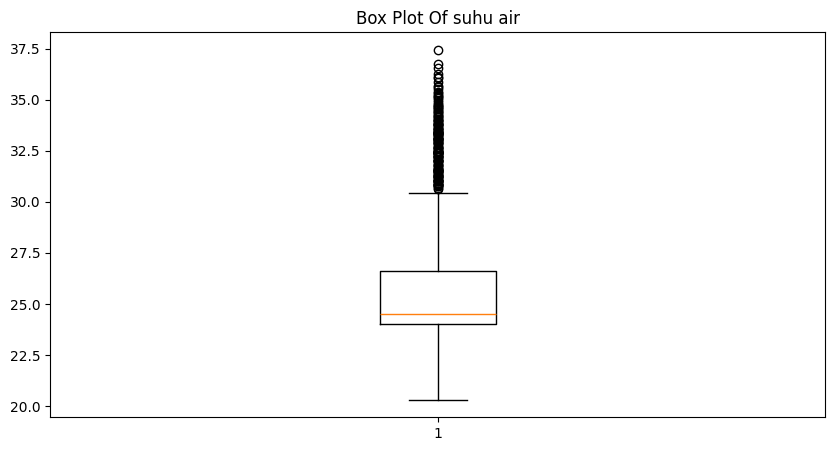

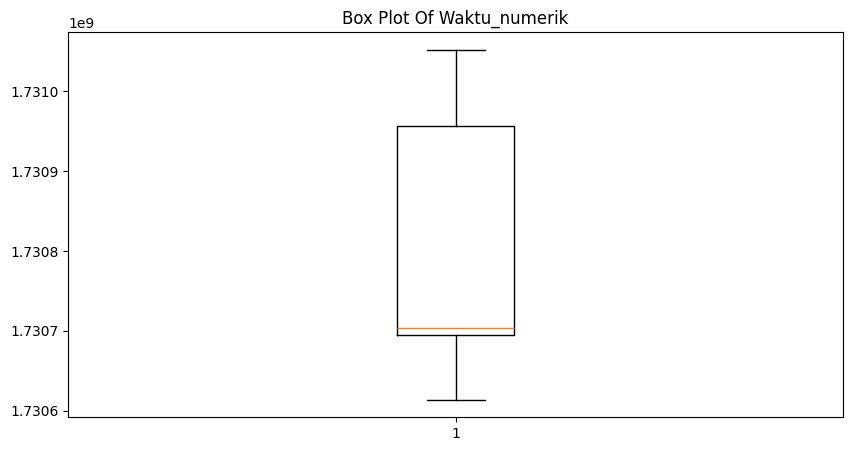

In [65]:
# Pilih hanya kolom dengan tipe data numerik
numeric_columns = df.select_dtypes(include=['number']).columns

# Plot boxplot hanya untuk kolom numerik
for feature in numeric_columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(x=df[feature])
    plt.title(f"Box Plot Of {feature}")
    plt.show()

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pilih hanya kolom dengan tipe data numerik
numeric_columns = df.select_dtypes(include=['number']).columns

# Tangani outlier dengan mengganti dengan median atau mean
for feature in numeric_columns:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Buat mask untuk outlier
    outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)

    # Ganti outlier dengan median (atau bisa ganti jadi df[feature].mean())
    median_value = df[feature].median()
    df.loc[outliers, feature] = median_value

df.head()

,Id,Waktu,suhu udara,humidty,suhu air,Waktu_numerik
0,1,2024-11-03 06:05:00,29.1,74.3,24.5,1.730614e+09
1,2,2024-11-03 06:06:00,29.1,74.6,24.5,1.730614e+09
2,3,2024-11-03 06:06:00,28.8,75.4,24.5,1.730614e+09
3,4,2024-11-03 06:07:00,28.7,76.0,24.5,1.730614e+09
4,5,2024-11-03 06:07:00,28.6,76.5,24.5,1.730614e+09


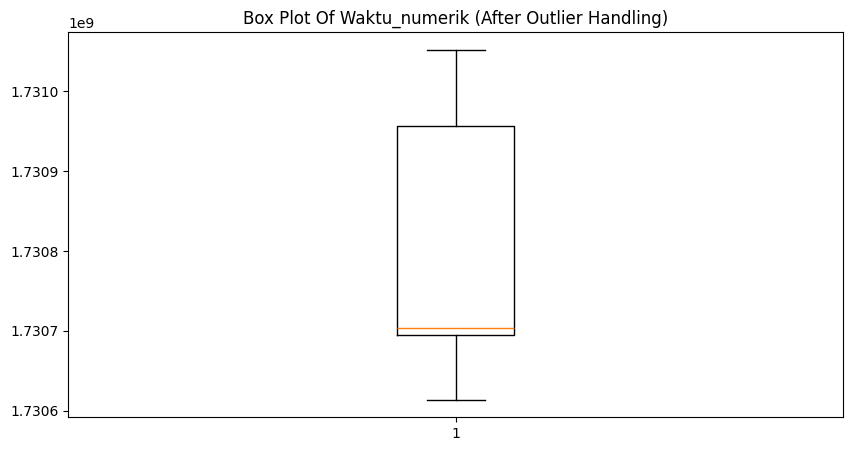

In [92]:
    # Plot boxplot setelah penanganan outlier
    plt.figure(figsize=(10, 5))
    plt.boxplot(x=df[feature])
    plt.title(f"Box Plot Of {feature} (After Outlier Handling)")
    plt.show()

## Standarisasi Data

In [93]:
df.isna().sum()

,0
Id,0
Waktu,0
suhu udara,0
humidty,0
suhu air,0
Waktu_numerik,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1035 non-null   int64         
 1   Waktu          1035 non-null   datetime64[ns]
 2   suhu udara     1035 non-null   float64       
 3   humidty        1035 non-null   float64       
 4   suhu air       1035 non-null   float64       
 5   Waktu_numerik  1035 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 48.6 KB


In [95]:
data_filter = df.copy()

In [96]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Copy data asli
data_scaled = data_filter.copy()

# Pilih hanya kolom numerik
numerical_cols = data_filter.select_dtypes(include=['number']).columns

# Standarisasi kolom numerik
data_scaled[numerical_cols] = scaler.fit_transform(data_filter[numerical_cols])

# Tampilkan hasil
data_scaled.describe()

,Id,Waktu,suhu udara,humidty,suhu air,Waktu_numerik
count,1.035000e+03,1035,1.035000e+03,1.035000e+03,1.035000e+03,1.035000e+03
mean,-5.492118e-17,2024-11-05 04:28:41.565217280,8.787388e-16,-7.688965e-16,2.141926e-15,-7.643930e-13
min,-1.730378e+00,2024-11-03 06:05:00,-1.016514e+00,-2.694600e+00,-1.850382e+00,-1.231568e+00
25%,-8.651891e-01,2024-11-04 04:42:00,-8.490632e-01,-1.041496e+00,-7.571804e-01,-6.312006e-01
50%,0.000000e+00,2024-11-04 06:57:00,-4.722995e-01,6.613258e-01,6.812428e-01,-5.714736e-01
75%,8.651891e-01,2024-11-07 05:19:30,9.928927e-01,7.731900e-01,6.812428e-01,1.296654e+00
max,1.730378e+00,2024-11-08 07:40:00,2.458085e+00,9.969183e-01,2.292277e+00,1.995903e+00
std,1.000483e+00,NaN,1.000483e+00,1.000483e+00,1.000483e+00,1.000483e+00


# LSTM Multivariate prediksi suhu air dengan feature suhu udara, humidty dan waktu

### Build model

In [123]:
# Fitur dan target
features = ['suhu udara', 'humidty', 'Waktu_numerik']
target = 'suhu air'

# Fungsi untuk membuat sequence multivariate
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# Siapkan data
X = df[features].values
y = df[target].values

# Feature scaling (normalisasi)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Ubah menjadi format LSTM
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Bangun model LSTM yang lebih kompleks
model = Sequential()

# Lapisan LSTM pertama dengan dropout
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Lapisan LSTM kedua dengan dropout
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Lapisan LSTM ketiga dengan dropout
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.3))

# Lapisan Dense untuk output
model.add(Dense(1))

# Kompilasi model
model.compile(optimizer='adam', loss='mse')

# Gunakan EarlyStopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Runing Model

In [118]:
# Latih model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 0.2096 - val_loss: 0.0664
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0699 - val_loss: 0.0332
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0388 - val_loss: 0.0345
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0370 - val_loss: 0.0239
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0310 - val_loss: 0.0209
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0259 - val_loss: 0.0207
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0257 - val_loss: 0.0214
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0255 - val_loss: 0.0194
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0230 - val_loss: 0.0176
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0207 - val_loss: 0.0164
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0198 - val_loss: 0.0161
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/ste

### Evaluasi model

In [119]:
# Prediksi pada data testing
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inversi scaling
y_pred_train = scaler_y.inverse_transform(y_pred_train)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_train = scaler_y.inverse_transform(y_train)
y_test = scaler_y.inverse_transform(y_test)

# Evaluasi model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE, MSE, RMSE, dan R² pada data training dan testing
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

# Menampilkan hasil evaluasi
print(f"Training MAE: {mae_train}, MSE: {mse_train}, RMSE: {rmse_train}, R²: {r2_train}")
print(f"Testing MAE: {mae_test}, MSE: {mse_test}, RMSE: {rmse_test}, R²: {r2_test}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training MAE: 0.08531942023300719, MSE: 0.021374970500269753, RMSE: 0.1462018142851509, R²: 0.8245711648912876
Testing MAE: 0.09176705560451777, MSE: 0.023002150039649102, RMSE: 0.15166459718618944, R²: 0.8077204516357822


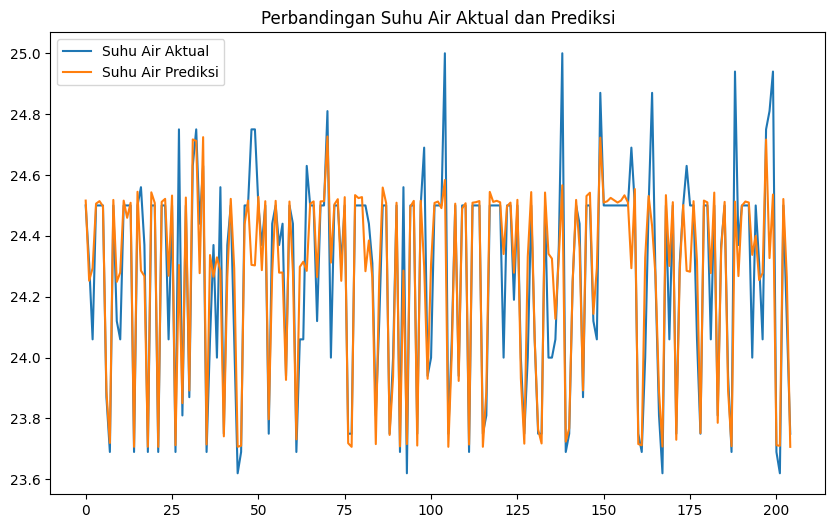

In [120]:
# Visualisasi Hasil
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Suhu Air Aktual')
plt.plot(y_pred_test, label='Suhu Air Prediksi')
plt.legend()
plt.title('Perbandingan Suhu Air Aktual dan Prediksi')
plt.show()

# Kesimpulan

Hasil ini menunjukkan performa model yang cukup baik, tetapi ada beberapa hal yang bisa diperhatikan:

1. MAE (Mean Absolute Error):
  - Training MAE: 0.0853
  - Testing MAE: 0.0918
  - MAE yang rendah menunjukkan bahwa prediksi model cukup dekat dengan nilai sebenarnya. Perbedaan antara training dan testing MAE juga relatif kecil, yang menunjukkan model tidak overfitting.

2. MSE (Mean Squared Error):
  - Training MSE: 0.0214
  - Testing MSE: 0.0230
  - MSE yang lebih rendah juga menunjukkan kesalahan prediksi yang relatif kecil.

3. RMSE (Root Mean Squared Error):
  - Training RMSE: 0.1462
  - Testing RMSE: 0.1517
  - RMSE yang lebih kecil lebih baik, dan angka ini juga menunjukkan kesalahan yang relatif kecil pada model.

4. R² (Coefficient of Determination):
  - Training R²: 0.8246
  - Testing R²: 0.8077
  - Nilai R² mendekati 1, yang berarti model dapat menjelaskan sebagian besar variansi data. R² yang tinggi menunjukkan model bekerja dengan baik dalam memprediksi data.